# TSSL Exam - 2020-10-21
This notebook contains the four exam problems.

* Please write your solutions directly in the notebook.

* Your submission should consist of: (i) an executable notebook (.ipynb file), **and** a pdf printout of the same notebook. Please make sure that all your answers are visible in the pdf file. To generate the pdf file from the notebook, you can either go to _File->Download as->PDF via LaTeX (.pdf)_, or go to _File->Print preview_ and "print" the web page as a pdf file.

* If relevant, hand-written calculations and drawings can be submitted alongside the notebook/pdf printout. Please scan/take a picture of your hand-written solutions and upload them in pdf, jpg or png format alongside the notebook. If you use this option, you need to **clearly mark in the notebook** that part of the solution is attached as a separate file and provide a reference to that file.  

* Apart from the exception mentioned above, the notebook should be self-contained and executable. Standard packages and the `tssltools` module that is **distributed along with the exam** may be imported. This module contains **all the auxiliary code that you have used in the labs**, i.e. from the `tssltools_lab#` files, regardless of whether or not these functions/classes are relevant for solving the exam. The `tssltools` module also contains some additional code that can come in handy (in that case, the relevant code is referred to in the problem formulation).
If you rely on external code that you have written (e.g. when solving the lab assignments in the course) it should be copied in to the notebook.

* **Responsible teacher:** Fredrik Lindsten, available over email (fredrik.lindsten@liu.se) or phone (070 085 07 90) during the exam.  


### Grades
The maximum number of points is 40 (8+13+12+7 for the four problems, respectively). The _tentative_ levels for the grades (A-F) are:
- A=37-40 points
- B=33-36 points
- C=23-32 points
- D=19-22 points
- E=15-18 points
- F=0-14 points (fail)

In [1]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Default figure size for plots.
# Feel free to change this if the suggested setting results in too small/large plots on your machine!
plt.rcParams["figure.figsize"] = (10,6)

## Problem 1:
(8 points)

**a)** The file `data_problem1.csv` contains a sequence of observations. In this problem you should do the following:

1. Load the data and split it into 80 % training and 20 % validation data.
2. Pre-process the data as you find appropriate.
3. Procude mean-squared-error curves for model orders in the range $p=1,\dots,10$. Plot both training and validation errors as two separate curves.
4. Based on the error curves, pick a final model order $p$ that you think is appropriate. Motivate your choice!

_Hint:_ You can use the functions `fit_ar` and `predict_ar_1step` from lab 1 (also available in `tssltools`).  

<div style="text-align: right"> (5p) </div>


In [3]:
data=pandas.read_csv('data_problem1.csv',header=0)
y = data['Data'].values

**Solution:**

In [4]:
from tssltools import fit_ar, predict_ar_1step

1. First we split into train/test

In [5]:
ndata = len(y)
ntrain = int(ndata*0.8)
ntest = ndata-ntrain

ytrain = y[:ntrain]

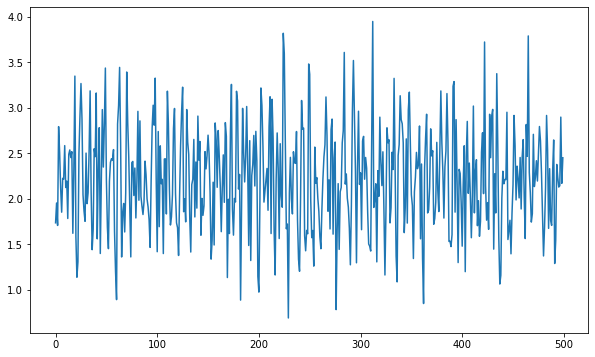

In [6]:
plt.plot(y)

2. The data has a non-zero mean, so we remove this by constant detrending.

In [7]:
# Detrend
c = np.mean(ytrain)
ytrain = ytrain - c
y = y - c

3. We run a loop over all model orders and compute the errors

In [8]:
help(predict_ar_1step)

Help on function predict_ar_1step in module tssltools:

predict_ar_1step(theta, y_target)
    Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.
    
    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n)



Run a train-validation data loop.

In [10]:
num_orders = 10
mse_val = np.zeros(num_orders)
mse_train = np.zeros(num_orders)
orders = range(1,num_orders+1)

for p in orders:
    th = fit_ar(ytrain, p)
    y_pred = predict_ar_1step(th, y)    
    mse_val[p-1] = np.mean( (y[ntrain:] - y_pred[ntrain-p:])** 2) # We skip the ntrain-p first elements, corresponding to training data
    mse_train[p-1] = np.mean( (y[p:ntrain] - y_pred[:ntrain-p])** 2)

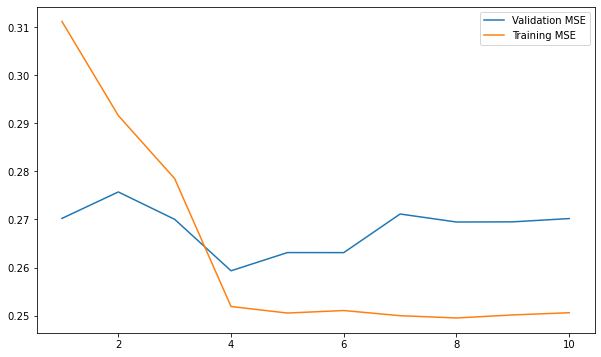

In [11]:
plt.plot(orders, mse_val)
plt.plot(orders, mse_train)
plt.legend(['Validation MSE','Training MSE'])


4. We see that both curves agree that $p=4$ seems to be a good choice. We have a "knee" in the training curve and a minimum in the validation curve.

In [13]:
p = np.argmin(mse)+1
print(p)

4


In [14]:
# Refit the model on the chosen order
th = fit_ar(ytrain, p)
print(th)

[ 0.20927804 -0.2446627  -0.12412318 -0.30890755]


___

**b)** For certain model orders $p$, the training error is larger than the validation error! Explain how this can possibly be the case (despite the fact that the model is optimized to minimize the training error).

<div style="text-align: right"> (2p) </div>

**Solution**

The training and test errors are computed based on the data, and they are therefore random. Even if we think about an ideal situation, where we simulate data from an AR$(p)$ model, split this into training and validation, and compute the MSEs, we could very well have "larger noise realization" in the training part of the data, resuling in a larger train MSE than validation MSE.

If the model has overfitted to the training data, that means that the training error is smaller than it would be for the "true model". In such cases train MSE < val MSE is typical, but for models that have _are not overfitted_, it could very well be that train MSE > val MSE.

___

**c)** Using the final model from part a), predict the value of $y_{n+1}$, where $n$ is the total number of data points above (both train and validation). What is the value of your prediction?

_Hint:_ If you were not able to solve part a), you can still solve this part of the problem. In that case, do the prediction using an AR($p=3$) model with a randomly chosen parameter vector.

<div style="text-align: right"> (1p) </div>

**Solution**

In [15]:
# Option 1: using the predict function
yy = predict_ar_1step(th, np.append(y, np.nan))[-1]  # We need to append an arbitrary number to extend the target range!
yy += c  # Add back the constant that we removed
print(yy)


2.22543518092118


In [16]:
# Option 2: Direct implementation
phi = np.flip(y[-p:]) # (y_{n}, ..., y_{n-p+1})^T
yy = np.sum( phi * th )
yy += c
print(yy)


2.22543518092118


## Problem 2:
(13 points)

**a)** In this problem we will study a simple **target tracking** model using a **LGSS** model
$$
    \begin{cases} \alpha_t = T \alpha_{t-1} + R \eta_t, & \eta_t \sim \mathcal{N}(0,Q), \\ y_t = Z \alpha_t + \varepsilon_t, & \varepsilon_t \sim \mathcal{N}(0,H). \end{cases}
$$

The model can be described as follows. Let the position of the target at time $t$ be $x_t$ and the velocity be $\dot{x}_t$. Betweeen each observation the time increment is $\Delta$, such that $x_{t+1} \approx x_t + \Delta \dot{x}_t$. The velocity is assumed to be approximataley constant. However, to add some stochasticity to the model we add a random acceleration at each time step. We model this acceleration as a Gaussian random variable $\eta_t$ with mean $0$ and variance $\sigma_{\eta}^2$. With the random acceleration, the velocity is updated as $\dot{x}_{t+1} = \dot{x}_t + \Delta \eta_t$. Furthermore, it can be shown that the acceleration will have a direct impact on the position update, so we model this as: $x_{t+1} = x_t + \Delta \dot{x}_t + \frac{\Delta^2}{2} \eta_t$.

Finally our observation is the position with additive Gaussian noise with mean 0 and variance $\sigma_{\varepsilon}^2$.

The datafilte `data_problem2a.csv` contains a sequence of observations from this model. Using this data you are tasked to do the following:

1. Setup the complete model by writing down the matrices $T$, $R$, $Q$, $Z$, and $H$. Also specify your hidden states $\alpha_t$. Remember to motivate your choices of matrices.
2. Set the initial means of the position and velocity based on the data, i.e. to the initial position and velocity implied by the data. Set the initial covariance matrix to be the identity matrix multiplied by 10.
3. Implement and run the Kalman filter for the above model using $\Delta = 0.2$, $\sigma_{\varepsilon}^2 = 1$, and $\sigma_{\eta}^2 = 0.1$.
4. Plot the filtered position (filter mean) together with the observations vs time.
5. Report the log-likelihood of the model on this data.

_Hint:_ The `LGSS` and `kfs_res` classes used in Lab 2 are available in the `tssltools` module.

<div style="text-align: right"> (7p) </div>

**Solution**

1. Set up the model matrices according to the model definition in the problem formulation and define the state vector.

We let $\alpha_t = (x_t, \dot{x}_t)^T$, which means that we can write the model in state space form as

\begin{align*}
    \alpha_{t+1} =
    \begin{pmatrix}
        x_{t+1} \\ \dot{x}_{t+1}
    \end{pmatrix} =
    \begin{pmatrix}
        x_t + \Delta \dot{x}_{t} \\ \dot{x}_{t}
    \end{pmatrix} +
    \begin{pmatrix} \frac{\Delta^2}{2} \eta_t \\ \Delta \eta_t
    \end{pmatrix} = 
    \begin{pmatrix}
        1 & \Delta \\ 0 & 1
    \end{pmatrix}\alpha_t +
    \begin{pmatrix}
        \frac{\Delta^2}{2} \\ \Delta
    \end{pmatrix}\eta_t
\end{align*}

where the observation equation is

\begin{align}
    y_t =
    \begin{pmatrix}
        1 & 0
    \end{pmatrix} \alpha_t + \varepsilon_t
\end{align}

In [41]:
from tssltools import LGSS, kfs_res

data2a = pandas.read_csv('data_problem2a.csv', header=None).values.flatten()

delta = 0.2
sigma2_eta = .1
sigma2_eps = 1.

# 1. From derivation above
T = np.array([ [1, delta], [0, 1] ])
R = np.array([ [delta**2 / 2], [delta] ])
Z = np.array([ [1, 0] ])

# 2. We set the initial mean for the position to the first observation (which is a noisy observation of the position).
#    The initial mean for the velocity is taken as the first order difference between the (noisy) positions at the first
#    two time steps, divided by the "sampling time" Delta
a1 = np.zeros(2)
a1[0] = data2a[0]
a1[1] = (data2a[1] - data2a[0])/delta
P1 = 10*np.eye(2)
model = LGSS(T, R, np.array([[sigma2_eta]]), Z, sigma2_eps, a1, P1)

help(model.get_params)

# 3. Kalman filter implementation
def kalman_filter(y, model: LGSS):
    """Kalman filter for LGSS model with one-dimensional observation.

    :param y: (n,) array of observations. May contain nan, which encodes missing observations.
    :param model: LGSS object with the model specification.
    
    :return kfs_res: Container class with member variables,
        alpha_pred: (d,1,n) array of predicted state means.
        P_pred: (d,d,n) array of predicted state covariances.
        alpha_filt: (d,1,n) array of filtered state means.
        P_filt: (d,d,n) array of filtered state covariances.
        y_pred: (n,) array of means of p(y_t | y_{1:t-1})
        F_pred: (n,) array of variances of p(y_t | y_{1:t-1})
    """

    
    ##### REMOVED FROM PROPOSED SOLUTIONS, BUT THIS IS THE SAME AS USED IN LAB 2

Help on method get_params in module tssltools:

get_params() method of tssltools.LGSS instance
    Return all model parameters.
    
    T, R, Q, Z, H, a1, P1 = model.get_params()



In [42]:
kf = kalman_filter(data2a,model)

4. Plot the filtered position (which is the first element of the state vector)

Text(0, 0.5, 'x_t')

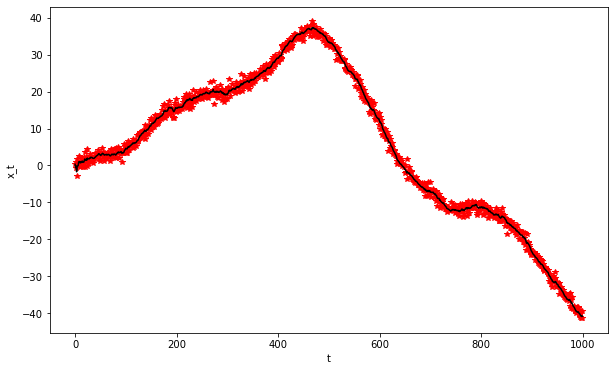

In [43]:
plt.figure()
plt.plot(data2a,'r*')
plt.plot(kf.alpha_filt[0,0,:],'k')
plt.xlabel('t')
plt.ylabel('x_t')

5. Log-likelihood

In [44]:
loglik1 = -0.5 * np.sum( np.log(2*np.pi*kf.F_pred) + (data2a - kf.y_pred)**2/kf.F_pred)
print(f'The log-likelihood is {loglik1}')

The log-likelihood is -1551.3274120685967


___

**b)** Often we are in the situation of missing data. In this task you will study the difference between the smoothing and filtering distributions when working with missing data. You should do the following:

1. Remove the data between index 500 and 650 from the data by setting those values to `np.nan`
2. Run the Kalman filter on this new data.
3. Run the Kalman smoother on the same data. The algorithm is provided in `tssltools`
4. Plot the data, the filtered mean and the smoothing mean.
5. Comment on the results

<div style="text-align: right"> (2p) </div>

**Solution**

In [46]:
from tssltools import kalman_smoother

# 1. Make a copy of the data and remove the missing observations
data2awithNan = data2a.copy()
data2awithNan[500:650] = np.nan

# 2-3. Run the KF+KS
kf = kalman_filter(data2awithNan, model)
ks = kalman_smoother(data2awithNan, model, kf)


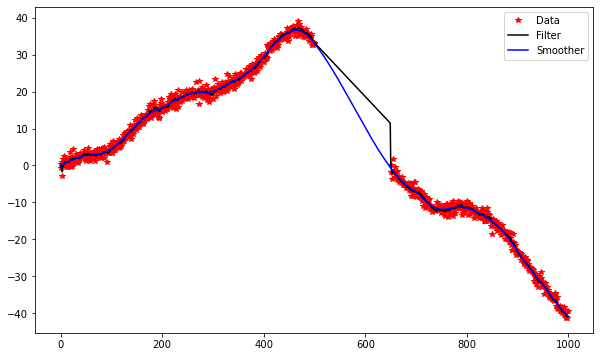

In [48]:
# 4. Plot
plt.figure()
plt.plot(data2awithNan,'r*')
plt.plot(kf.alpha_filt[0,0,:],'k')
plt.plot(ks.alpha_sm[0,0,:],'b')
plt.legend(['Data','Filter','Smoother'])

5. Comment on result

The filter mean propagates the position in a straight line in the interval of missing observations. Without having any information available, our best guess (based on our model) is that the velocity is constant and the position will then follow a straight line. When we get a new observation at $t=650$, the mean suddenly jumps to the correct position, based on this new information.

The smoother conditions on the future observations as well, so the smoothed mean of the position connects the two parts of the data using a smooth curve.

___

**c)** Now we will move away from the one-dimensional target tracking and study target tracking in two-dimensions. The observations are noisy estimates of the position and we again model the system using a LGSS model,
$$
    \begin{cases} \alpha_t = T \alpha_{t-1} + R \eta_t, & \eta_t \sim \mathcal{N}(0,Q), \\ z_t = Z \alpha_t + \varepsilon_t, & \varepsilon_t \sim \mathcal{N}(0,H). \end{cases}
$$

We now have two positions $(x^1_t, x^2_t)$ with their respective velocities $(\dot{x}^1_t, \dot{x}_t^2)$. Both of these dimensions should behave independently exactly like the 1-dimensional case in **a)**.

The observations $y_t$ should be a noisy observation of the position where the noise for each coordinate is independent Gaussian random variables with zero meean and variance $\sigma_{\varepsilon}^2$.

The datafile `data_problem2c.csv` contains a sequence of noisy observations of a target moving in 2d. For this question you should do the following:

1. Write down the matrices and state-vector for this model. You may reference the matrices from **a)** even if you didn't solve that part. Remember to motivate your answer.
2. Set the initial position to be the initial observation for both coordinates and the initial velocities to be the velocities implied by the first two observations. Let the initial variance estimate `P1` be a diagonal matrix with $10$ on the diagonal.
3. Implement and run the Kalman filter for the above model using $\Delta = 0.2$, $\sigma_{\varepsilon}^2 = 1$, and $\sigma_{\eta}^2 = 0.1$.
4. Plot the filtered trajectory, i.e. the filtered mean estimate of $x^2_t$ vs $x^1_t$.

_Hint: Now that the dimension of the observation is 2 some modifications to the Kalman filter is necessary. Copy the Kalman filter code from above and make the necessary adjustments. The code below imports the data and reshapes it into the shape `(2,1,1001)`, use the same shape for `y_pred` and let `F_pred` have the shape `(2,2,1001)`. Make sure you use matrix multiplication where needed._

<div style="text-align: right"> (4p) </div>

In [51]:
data2c = pandas.read_csv('data_problem2c.csv', header=None).values.reshape((2,1,1001))

**Solution**

1. We stack two independent copies of the model above, one for each coordinate.

The state vector is given by
\begin{align*}
    \alpha_t &= (\alpha_t^1, \alpha_t^2)^T
\end{align*}

and the new system matrices, denoted by $T', R', Z'$, are given by

\begin{align*}    
    T' &=
    \begin{pmatrix}
        T & 0 \\ 0 & T
    \end{pmatrix} \\
    R' &=
    \begin{pmatrix}
        R & 0 \\ 0 & R
    \end{pmatrix} \\
    Z' &=
    \begin{pmatrix}
        Z & 0 \\ 0 & Z
    \end{pmatrix}
\end{align*}


In [52]:
from tssltools import LGSS, kfs_res

delta = 0.2
sigma2_eta = .1
sigma2_eps = 1

T = np.array([ [1, delta, 0, 0], [0, 1, 0, 0], [0, 0, 1, delta], [0, 0, 0, 1] ])
R = np.array([ [delta**2 / 2, 0], [delta, 0], [0, delta**2 / 2], [0, delta] ])
Z = np.array([ [1, 0, 0, 0], [0, 0, 1, 0] ])

# We set the initial means independently as above for the two coordinates
alpha = np.zeros((4,1,1001))
alpha[1,0,0] = (data2c[0,0,1] - data2c[0,0,0])/delta
alpha[3,0,0] = (data2c[1,0,1] - data2c[1,0,0])/delta

a1 = np.zeros(4)
a1[1] = (data2c[0,0,1] - data2c[0,0,0])/delta
a1[3] = (data2c[1,0,1] - data2c[1,0,0])/delta
P1 = 10*np.eye(4)

model = LGSS(T, R, sigma2_eta*np.eye(2), Z, sigma2_eps*np.eye(2), a1, P1)

help(model.get_params)


def kalman_filter_2d(y, model: LGSS):
    """Kalman filter for LGSS model with one-dimensional observation.

    :param y: (n,) array of observations. May contain nan, which encodes missing observations.
    :param model: LGSS object with the model specification.
    
    :return kfs_res: Container class with member variables,
        alpha_pred: (d,1,n) array of predicted state means.
        P_pred: (d,d,n) array of predicted state covariances.
        alpha_filt: (d,1,n) array of filtered state means.
        P_filt: (d,d,n) array of filtered state covariances.
        y_pred: (n,) array of means of p(y_t | y_{1:t-1})
        F_pred: (n,) array of variances of p(y_t | y_{1:t-1})
    """

    ##### REMOVED FROM PROPOSED SOLUTIONS, BUT THIS IS A SMALL MODIFICATION OF THE KF USED IN LAB 2


Help on method get_params in module tssltools:

get_params() method of tssltools.LGSS instance
    Return all model parameters.
    
    T, R, Q, Z, H, a1, P1 = model.get_params()



In [53]:
kf = kalman_filter_2d(data2c, model)

4. Plot

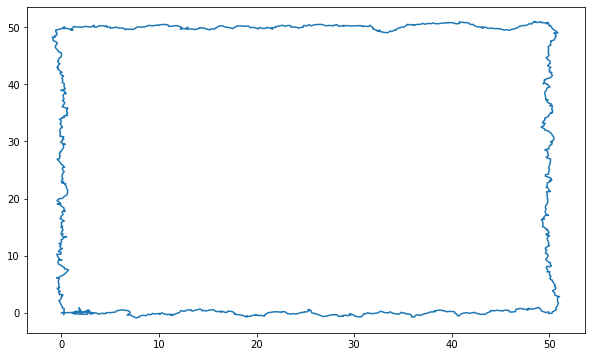

In [55]:
plt.figure()
plt.plot(kf.alpha_filt[0,0,:], kf.alpha_filt[2,0,:])

## Problem 3:
(12 points)

The file `data_problem3.csv` contains a sequence of observations. We will model this sequence using the following non-linear state space model,
$$
    \begin{cases} \alpha_{t+1} = 0.8 \alpha_t + \frac{\alpha_t}{1 + \alpha_t^2} + \sigma_{\varepsilon} \varepsilon_t, & \varepsilon_t \sim \mathcal{N}(0,1) \\
    y_t = \frac{\alpha_t^2}{20} + \sigma_{\eta} \eta_t & \eta_t \sim \mathcal{N}(0,1).
    \end{cases}
$$
with initial distribution $\alpha_1 \sim \mathcal{N}(2,\sigma_{\varepsilon}^{2})$.

**a)** To implement a bootstrap particle filter we need to perform three operations, propagation, weighting, and resampling. In this problem you should do the following:

1. Find the conditional distribution of $y_t \mid \alpha_t$.
2. Implement a function that takes $N$ particles $\alpha_t^i$ and propagates them to $\alpha_{t+1}^i$.
3. Implement a function that takes $N$ particles $\alpha_t^i$ and an observation $y_t$ and calculates the log-weights $\log \omega_t^i$.

<div style="text-align: right"> (5p) </div>

**Solution:**

1. Conditioning on $\alpha_t$ means that we can view the first term in the observation equation as a constant mean. With additive Gaussian noise (second term of the equations), we get

\begin{align*}
    p(y_t | \alpha_t) = \mathcal{N}\left(y_t | \frac{\alpha_t^2}{20}, \sigma_{\eta}^2\right).
\end{align*}

In [57]:
# 2. Propagation function
# We sample new particles from the transition/state update equation conditionally on the current particles
def propagate(particles, sigma_eps):
    N = len(particles)
    new_particles = .8 * particles +  particles / ( 1 + particles**2)  + sigma_eps*np.random.randn(N)
    return new_particles

# 3. Log-weight computation
# The log-weights are given by the log-pdf from part 1, evaluated at all particles
def logweight_fun(particles, y, sigma_eta):
    logweights = - 1/2 * ( y - particles**2/20 )**2 / (sigma_eta**2)
    return logweights

----

**b)** using the functions from the previous part implement a **Bootstrap Particle Filter** that runs on the data. You should solve the following parts:

1. Set the parameters $\sigma_{\varepsilon} = 1$ and $\sigma_{\eta} = 0.5$
2. Use the bootstrap particle filter to calculate the filtered variance of the state-process.
$$
    \mathbb{V}[\alpha_t \mid y_{1:t}] = \mathbb{E}[\alpha_t^2 \mid y_{1:t}] - \mathbb{E}[\alpha_t \mid y_{1:t}]^2
$$
3. Provide a plot of your variance estimates and provide a numerical estimate to $\sum_{t=1}^{n} \mathbb{V}[\alpha_t \mid y_{1:t}]$

Use $N = 200$ particles when performing your estimates.

If you failed to do the first part you can use the functions `propagate_wrong` and `logweight_fun_wrong` from the `tssltools` module to implement and run your bootstrap particle filter.

<div style="text-align: right"> (7p) </div>

**Solution:**

In [58]:
# Helper function

def exp_norm(logW):
    const = np.max(logW)
    W = np.exp(logW - const)
    sumofweights = np.sum(W)
    logZ = np.log(sumofweights) + const
    W = W / sumofweights
    return W, logZ

In [60]:
#from tssltools import propagate_wrong, logweight_fun_wrong

par = np.array([1,.5]) # 1. State and observation noise
N = 200

# 2. Particle filter implementation
def bpf(y, N, par):
    n = len(y)
    particles = np.zeros((n,N))
    logWeights = np.zeros((n,N))
    weights = np.zeros((n,N))
    
    estMean = np.zeros(n)
    estSquare = np.zeros(n)
    
    particles[0,:] = 2 + par[0]*np.random.randn(N)
    logWeights[0,:] = logweight_fun(particles[0,:], y[0], par[1])
    weights[0,:],_ = exp_norm(logWeights[0,:])
    
    estMean[0] = np.sum(weights[0,:]*particles[0,:])
    estSquare[0] = np.sum(weights[0,:] * particles[0,:]**2)
    
    for t in range(1,n):
        # RESAMPLE
        ind = np.random.choice(N,N,True,p=weights[t-1,:])
        
        # PROPAGATE
        particles[t,:] = propagate(particles[t-1,ind], par[0])
        
        # WEIGHTING
        logWeights[t,:] = logweight_fun(particles[t,:], y[t], par[1])
        weights[t,:], _ = exp_norm(logWeights[t,:])
        
        # ESTIMATES
        estMean[t] = np.sum(weights[t,:] * particles[t,:]) # Estimate of  E[alpha_t | y_{1:t}]
        estSquare[t] = np.sum(weights[t,:] * particles[t,:]**2) # E[alpha_t^2 | y_{1:t}]
    
    return estMean, estSquare
    
    

In [61]:
# ...load the data
data=pandas.read_csv('data_problem3.csv', header=None)
y = data.values.flatten()

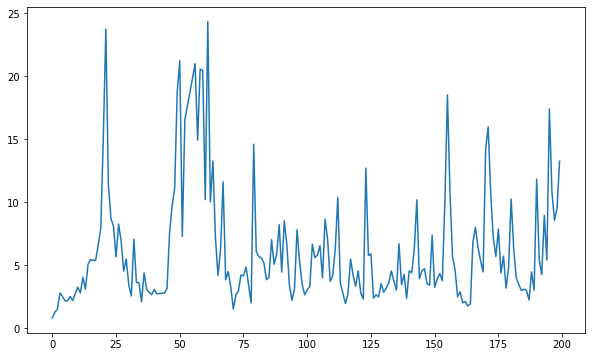

In [64]:
# ... Run the PF
estM, estS = bpf(y,N,par)

# 3. We compute the variance estimate and plot the result
estVar = estS - estM**2
plt.figure()
plt.plot(estVar)

In [65]:
print(f'The sum of variances is {np.sum(estVar)}')

The sum of variances is 1251.5471406661095


## Problem 4:
(7 points)

In this problem we will revisit the Sunspot data and RNN model from Lab 4.

In [66]:
# Load TF/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [67]:
# Read the data
data=pandas.read_csv('Sunspots.csv',header=0)
dates = data['Date'].values
y = data['Monthly Mean Total Sunspot Number'].values
ndata=len(y)

# We define a train/test split, here with 70 % training data
ntrain = int(ndata*0.7)
print(f'Total number of data points: {ndata}')
print(f'Number of training data points: {ntrain}')

MAX_VAL = 400
y = y/MAX_VAL

Total number of data points: 3252
Number of training data points: 2276


We will only consider computing predictions, so we load a pretrained model from the lab.

In [68]:
# A stacked model with 3 layers of LSTM cells, two Dense layers with Relu activation and a final linear output layer
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, batch_input_shape=(1,None,1), return_sequences=True, stateful=True),
  tf.keras.layers.LSTM(64, batch_input_shape=(1,None,1), return_sequences=True, stateful=True),
  tf.keras.layers.LSTM(64, batch_input_shape=(1,None,1), return_sequences=True, stateful=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 64)             33024     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 64)             33024     
_________________________________________________________________
dense (Dense)                (1, None, 32)             2080      
_________________________________________________________________
dense_1 (Dense)              (1, None, 16)             528       
_________________________________________________________________
dense_2 (Dense)              (1, None, 1)              17        
Total params: 85,569
Trainable params: 85,569
Non-trainable params: 0
____________________________________________________

In [69]:
model.load_weights('./')

___

**a)** Using the pretrained model above, compute 1-step predictions for all the _test data points_. That is, compute

\begin{align*}
    &\hat y_{t|t-1}, & t&=n_{\text{train}}+1, \dots, n_{\text{data}}
\end{align*}
Plot the predictions and the test data in the same figure.

Two things that you need to take into consideration:
1. The RNN is trained using $y_{t-1}$ as input and the residual $\tilde y_t = y_t - y_{t-1}$ as output at time $t$.
2. The prediction at time $t$ is allowed to depend on all data points $y_s$ for $1 \leq s < t$. Specifically, since the training data preceeds the test data, the hidden state of the RNN should depend on the training data also when predicting the test data points.

<div style="text-align: right"> (2p) </div>


**Solution**

In [72]:
ntest = ndata - ntrain

model.reset_states() # Not really needed since this is the first call, but still

# Predict on all data using the final model.
# We predict using y_1,...,y_{n-1} as inputs, resulting in predictions of the values y_2, ..., y_n
y_pred = model.predict(y[:-1].reshape(1, ndata-1, 1)).flatten() + y[:-1]

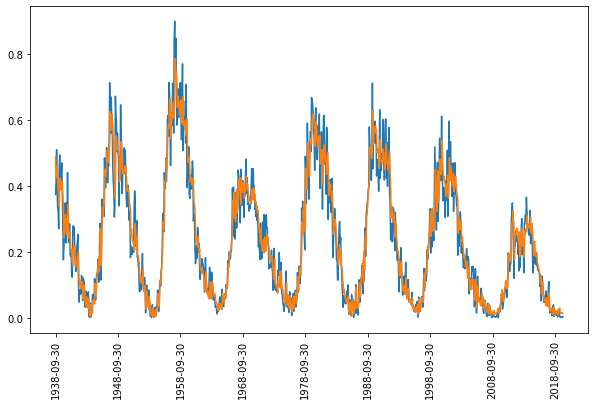

In [73]:
plt.plot(dates[ntrain:], y[ntrain:]) # Test data
plt.xticks(range(0, ntest, 120), dates[ntrain::120], rotation = 90);  # Show only one tick every 10th year for clarity
plt.plot(dates[ntrain:], y_pred[ntrain-1:]) # We shift by one since the first prediction is for time 2

___

**b)** Using the pretrained model above, compute a _free-running simulation_ for all the _test data points_, conditionally on the training data. That is, compute

\begin{align*}
    &\hat y_{t|n_{\text{train}}}, & t&=n_{\text{train}}+1, \dots, n_{\text{data}}
\end{align*}

Not that, in this case, the prediction at time $t > n_{\text{train}}$ is allowed to depend only on the data points $y_{1:n_{\text{train}}}$. As above, this dependence should affect the hidden state of the RNN when predicting the test data points.

Plot the predictions (from the simulation) and the test data in the same figure.

_Hint:_ The RNN hidden state is (re-)initialized to zero by calling `model.reset_states()`, and this is the state we should use at time $t=0$.

_Hint:_ You need to feed the model's predictions back as inputs for computing long-range predictions using the RNN.

<div style="text-align: right"> (4p) </div>


**Solution**

In [74]:
model.reset_states()

In [76]:
# First predict on all training data.
# We will not use these predictions (except the last one), but this will set the state of the RNN to the correct value at
# time t=ntrain

# We predict using y_1,...,y_{ntrain} as inputs, resulting in predictions of the values y_2, ..., y_{ntrain+1}
y_pred_train = model.predict(y[:ntrain].reshape(1, ntrain, 1)).flatten() + y[:ntrain]

In [77]:
# Now we create a vector of simulated values for t=ntrain+1, ..., ndata
y_sim = np.zeros(ntest)
y_sim[0] = y_pred_train[-1]  # Final one-step prediction is first simulation, y_{ntrain+1|ntrain}

# We predict as before, but instead of feeding the actual data in as inputs, we use the previous predictions.
# This means that we need to call the predict function in a loop, one time step at a time
for t in range(1,ntest): # Free running simulation    
    y_sim[t] = model.predict(y_sim[t-1].reshape(1, 1, 1)).flatten() + y_sim[t-1]

In [ ]:
plt.plot(dates[ntrain:], y[ntrain:]) # Test data
plt.xticks(range(0, ntest, 120), dates[ntrain::120], rotation = 90);  # Show only one tick every 10th year for clarity
plt.plot(dates[ntrain:], y_sim)

___

**c)** The RNN above only used $y_{t-1}$ as input at time $t$. By looking at the raw data we can see a clear (roughly) 11-year cycle. Propose a way to explicitly take this cyclic behavior into account, by augmenting the input to the RNN.

<div style="text-align: right"> (1p) </div>


**Solution**

Viewed as a regression model, the RNN uses inputs $x_t = y_{t-1}$ to predict the output $y_t$. We can augment the input with additional information. For instance, to capture the 11-year cycle we can add a second element of the input vector $x_t = (y_{t-1}, u_t)$ where $u_t = sin(\Delta t)$